In [1]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import scipy.io.wavfile as wf

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab

from math import sqrt

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and rescales the amplitude
# (which must be given in relative units, in range 0 .. 1) so that 
#
#           max(X) = A * MAX_AMP
#

def scaleSignal(X,A=1.0):
        s = MAX_AMP*A/max(X)
        return np.array( [ x*s for x in X ] ).astype(int)

    
# create a signal from a spectrum represented as triples (freq,amp,phase)
# mode = 'absolute' (amplitude in spectrum is in range MIN_AMP .. MAX_AMP)
#      = 'relative' (amplitude in spectrum is in range 0 .. 1)
# if amp != None, will be resca

def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int) 
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

# Some sample spectra
    
def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []
    
instruments =    ['triangle','square', 'bell', 'organ', 'steelstring', 'clarinet']

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

min_freq = Freqs['A0']
max_freq = Freqs['C8']
min_period = SR/max_freq
max_period = SR/min_freq

print(min_period)
print(max_period)

# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import scipy.io.wavfile as wf

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab

from math import sqrt

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and rescales the amplitude
# (which must be given in relative units, in range 0 .. 1) so that 
#
#           max(X) = A * MAX_AMP
#

def scaleSignal(X,A=1.0):
        s = MAX_AMP*A/max(X)
        return np.array( [ x*s for x in X ] ).astype(int)

    
# create a signal from a spectrum represented as triples (freq,amp,phase)
# mode = 'absolute' (amplitude in spectrum is in range MIN_AMP .. MAX_AMP)
#      = 'relative' (amplitude in spectrum is in range 0 .. 1)
# if amp != None, will be resca

def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int) 
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

# Some sample spectra
    
def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []
    
instruments =    ['triangle','square', 'bell', 'organ', 'steelstring', 'clarinet']

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

min_freq = Freqs['A0']
max_freq = Freqs['C8']
min_period = SR/max_freq
max_period = SR/min_freq

print(min_period)
print(max_period)

# Display a graph of a signal

def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 10
T = np.arange(SR*1)
X = MAX_AMP * np.sin(2*pi*f*T/SR)

# displaySignal(X)

import time
from tqdm import tqdm, trange

10.535094293377469
1603.6363636363637
10.535094293377469
1603.6363636363637


In [2]:
# File: Yin.py
# Author: Wayne Snyder
# Date: Jul 30 2020
# Description: This is an implementation of the Yin Algorithm, from
#        http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf


def Yin(X,t=0,window_size=4410,threshold=0.1,display=False):

    # normalize X to prevent overflow when multiplying
    X = np.array([x/MAX_AMP for x in X])

    W = window_size//2    # can only calculate lag times up to half of window size
    
    X1 = X[t:(t+W)]       # stationary window of width W

    # Calculate d_t(tau),  p.1919
    
    d_t = np.array([np.sum((X1 - X[(tau+t):(tau+t+W)])**2) for tau in range(W)])

    # Calculate the cumulative mean normalized difference function d1_t(tau) = d'_t(tau)
    
    #  d1_t(tau) = 1 for tau = 0
    #            = d_t(tau) / mean(d_t(1), ..., d_t(tau))  otherwise
    #              = tau*d_t(tau)/(d_t(1)+ ... +d_t(tau))
    
    # Cumulative sum of [x0,x1,x2, .... ] is [x0, x0+x1, x0+x1+x2, ... ]
    # so this will calculate the denominator above:
    
    cumm_d_t = np.cumsum(d_t)

    d1_t = np.array([ 1 if (tau==0) else tau*d_t[tau]/cumm_d_t[tau] for tau in range(W)])

    # Now calculate minima in d1_t and find first one that is below
    # a fixed threshold; if none is below threshold, then choose overall global minimum
    
    # note that you can't choose tau as last slot (len(d1_t)-1) because such a tau = 
    # can never be a "valley" (it doesn't have a right neighbor to be less than). 
    # Similarly, tau can not be < 3 because tau = 2 corresponds to period 2, and 
    # frequency 44100/2 = 22050 = Nyquist Limit!

    tau = None
    
    for t1 in range(3,len(d1_t)-1):             
        if d1_t[t1] < threshold and d1_t[t1-1] > d1_t[t1] and d1_t[t1] < d1_t[t1+1]:
            tau = t1
            break
            
    if tau == None:
#         print("Warning: Using global minimum!")
        # index of first global minimum
        # but not the very last slot (cf. len(d1_t)-1 above), so find min in d1_t[:-1]
        tau = (np.where(d1_t[:-1] == np.amin(d1_t[:-1])))[0][0]
        
    (x1,x2,x3) = (tau-1,tau,tau+1)
    (y1,y2,y3) = (d1_t[tau-1],d1_t[tau],d1_t[tau+1])
    

    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2))   
    B = (x3**2 * (y1 - y2) + x2**2 * (y3 - y1) + x1**2 * (y2 - y3)) 
    
    interpolated_tau = - B/(2*A)

    if display:
     
        plt.figure(figsize=(10,5))
        plt.title("Signal Window")
        plt.plot(X1)
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Difference Function")
        plt.plot(d_t)
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Normalized Difference Function")
        plt.plot(d1_t)
        plt.show()

    return ( SR/interpolated_tau, SR/tau,d_t,d1_t)

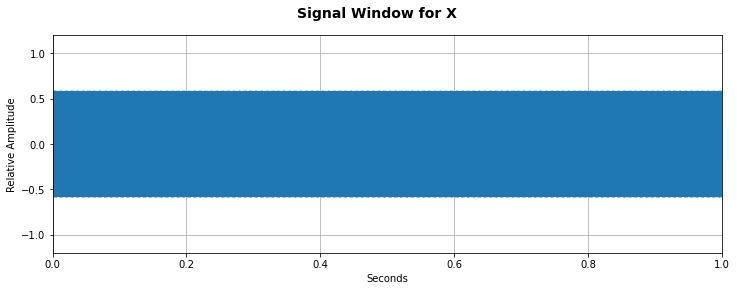

In [3]:
f0 = 330
X = makeSignal(makeSpectrum('clarinet', f0))

displaySignal(X)
Audio(X, rate=SR)

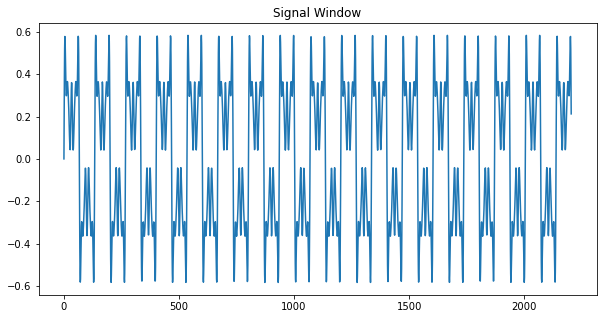

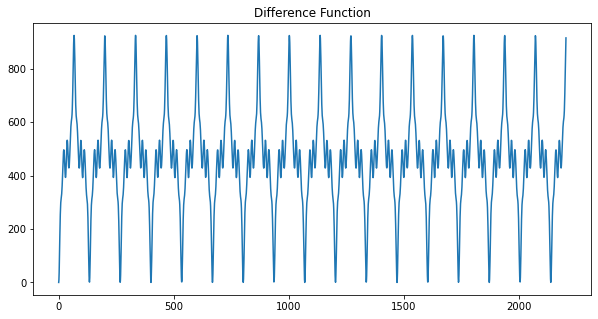

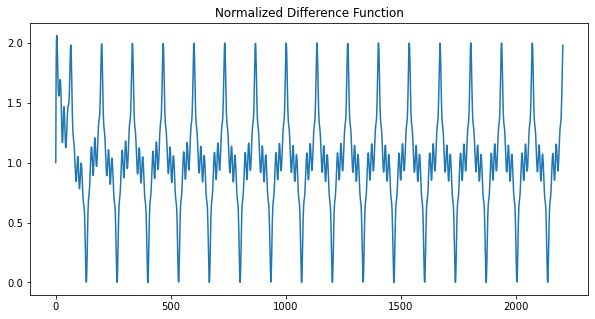

329.99982106769187
took time:  0.33507779999999965


In [4]:
tic = time.perf_counter()
f_interp, f_no_interp, diff, norm_diff = Yin(X, display=True)
toc = time.perf_counter()
print(f_interp)
print("took time: ",toc-tic)

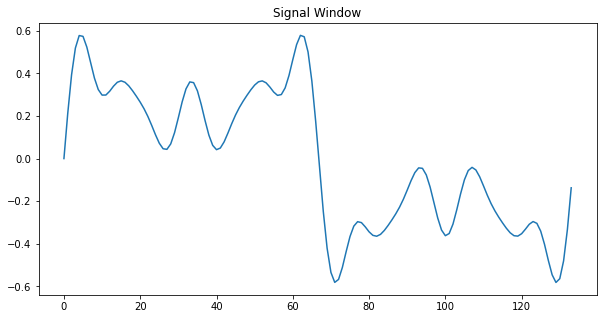

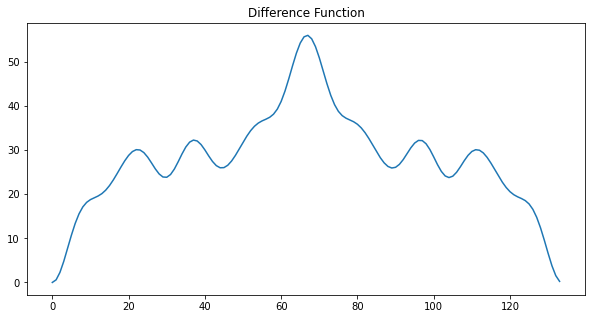

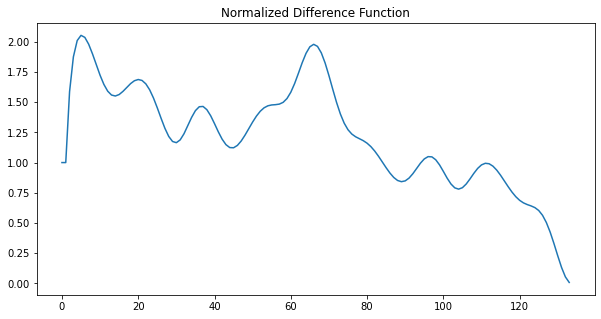

329.22855419845183
took time:  0.2986260000000005


In [5]:
tic = time.perf_counter()
f_interp, f_no_interp, diff, norm_diff = Yin(X, display=True, window_size=(SR//f0+1)*2)
toc = time.perf_counter()
print(f_interp)
print("took time: ",toc-tic)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 49.20it/s]


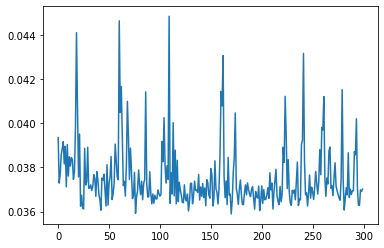

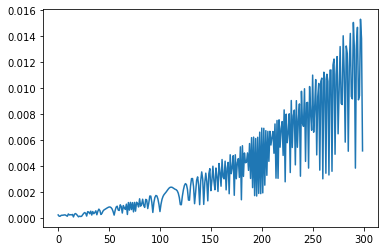

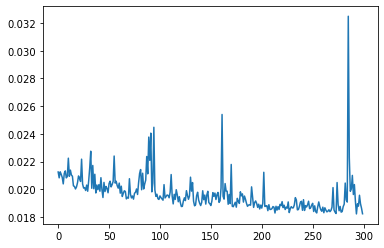

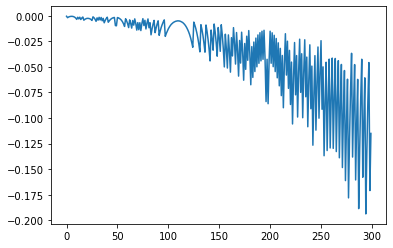

In [9]:
def yin_perf_analysis(X, f0, window_size=4410):
    tic = time.perf_counter()
    guess_interp, guess_no_interp, dt, dt_m = Yin(X, window_size=window_size)
    toc = time.perf_counter()
    return toc-tic, (guess_interp - f0)

f0_range = range(100,400)
times_large = [yin_perf_analysis(makeSignal([(freq, 1, 0)]), freq) for freq in tqdm(f0_range)]
times_small = [yin_perf_analysis(makeSignal([(freq, 1, 0)]), freq, window_size=(SR//freq+1)*2) for freq in tqdm(f0_range)]

t_l = [val[0] for val in times_large]
t_s = [val[0] for val in times_small]
e_l = [val[1] for val in times_large]
e_s = [val[1] for val in times_small]

plt.plot(t_l)
plt.show()
plt.plot(e_l)
plt.show()

plt.plot(t_s)
plt.show()
plt.plot(e_s)
plt.show()
